In [1]:
import pandas as pd
import numpy as np
import logging 
import math

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler # to scale data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

# NN model
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import SGD #test keras

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns


# machine learning model to predict the loss rate of the beam in the main collimators as a function of a set of operational parameters
# The loss rate is expressed through the IR7_lifetime variable (high IR7 lifetime = low loss rate)
# The input variables are retrieved from the CERN Logging Database, arranged in dataframes and saved in csv files in a separate notebook


Using TensorFlow backend.


In [2]:
pd.set_option('display.max_rows', 200)

train = True

# use logger for printouts
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [3]:
logger.info('Reading input files')
files = ["data/df_6772.csv","data/df_6909.csv"]
frames = []

# read input dataframes and print the structure of the first one. One column for each relevant variable.
for i,f in enumerate(files):
    frames.append(pd.read_csv(f))
    if i==0 :
        print('Printing head, columns and shape of first dataframe')
        print(frames[i].head())
        print(frames[i].columns)
        print(frames[i].shape)

INFO:root:Reading input files


Printing head, columns and shape of first dataframe
     Unnamed: 0  LifetimeB1  LifetimeB2  ATLASlumi  CMSlumi         IntB1  \
0  1.528550e+09      13.398      17.711   0.000000      0.0  3.000000e+09   
1  1.528550e+09      18.033      11.097   0.003093      0.0  2.817678e+14   
2  1.528550e+09       9.961      11.613   0.006331      0.0  2.815667e+14   
3  1.528550e+09       3.621      14.621   0.005287      0.0  2.813575e+14   
4  1.528550e+09       6.193      20.903   0.007324      0.0  2.811533e+14   

          IntB2      Ene  Betastar_IP1  Betastar_IP5  Xing_IP1  Xing_IP5  \
0 -4.100000e+08  54160.0          25.0          25.0     130.0     130.0   
1  2.814936e+14   3755.0          25.0          25.0     130.0     130.0   
2  2.812258e+14   3775.0          25.0          25.0     160.0     160.0   
3  2.811517e+14   3815.0          25.0          25.0     160.0     160.0   
4  2.810994e+14   3865.0          25.0          25.0     160.0     160.0   

   BMode  
0    7.0  
1    7

In [4]:
logger.info('Concatenating DataFrames')        
df = pd.concat(frames)

INFO:root:Concatenating DataFrames


In [5]:
# I want only beam mode >5 <12, i.e. between prepare energy ramp and stable beams (included)
# Below: list of beam mode codes as logged in the "HX:BMODE" timber variable
#setup 2
#injection probe beam 3
#injection setup beam 4
#injection physics beam 5
#prepare ramp 6
#ramp 7
#flat top 8
#squeeze 9
#adjust 10
#stable beams 11
#unstable beams 12
#beam dump 13
#ramp down 14
#recovery 15
#inject and dump 16
#circulate and dump 17
#abort 18
#cycling 19
#beam dump warning 20
#no beam 21
#prepare injection 22

logger.info("Cleaning beam mode: keep >5 and <12")
df = df[(df['BMode']>5) & (df['BMode']<12)]

logger.info('Converting DataFrame into np arrays')
X = df[['ATLASlumi', 'CMSlumi', 'IntB1', 'Ene', 'Betastar_IP1', 'Betastar_IP5', 'Xing_IP1','Xing_IP5', 'BMode']].values
y = df['LifetimeB1'].values

INFO:root:Cleaning beam mode: keep >5 and <12
INFO:root:Converting DataFrame into np arrays


In [6]:
# scaling (necessary for the stability of the ML model)
logger.info('Scaling features')
sc = MinMaxScaler() # best scaler so far
#sc = RobustScaler()
#sc = StandardScaler()
X = sc.fit_transform(X)
y = y.reshape(-1,1) # arrange y vector in correct format
y = sc.fit_transform(y)

INFO:root:Scaling features


In [7]:
logger.info('Train and test splitting')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

INFO:root:Train and test splitting


In [8]:
logger.info('Model definition and compilation')
model = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model.add(Dense(10, input_dim=9, activation='relu', kernel_initializer='normal')) # Dense: fully connected layer
model.add(Dense(80, activation='relu', kernel_initializer='normal'))
model.add(Dense(1, kernel_initializer='normal')) # to check: best activation function for single-value output

INFO:root:Model definition and compilation


In [9]:
# loss function and optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
# training 
logger.info('Model training')
history = model.fit(X_train, y_train, epochs=100, batch_size=50, # 
                    validation_data = (X_test,y_test)) # show accuracy on test data after every epoch
# Prediction
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

model.save('models/my_model.h5')

INFO:root:Model training


Train on 11519 samples, validate on 4938 samples
Epoch 1/100
11519/11519 [==============================] - 1s 82us/step - loss: 8.5327e-04 - val_loss: 6.3284e-04
Epoch 2/100
11519/11519 [==============================] - 1s 72us/step - loss: 6.7395e-04 - val_loss: 6.2182e-04
Epoch 3/100
11519/11519 [==============================] - 1s 63us/step - loss: 6.6803e-04 - val_loss: 6.5008e-04
Epoch 4/100
11519/11519 [==============================] - 1s 68us/step - loss: 6.5837e-04 - val_loss: 6.3153e-04
Epoch 5/100
11519/11519 [==============================] - 1s 74us/step - loss: 6.5445e-04 - val_loss: 6.3741e-04
Epoch 6/100
11519/11519 [==============================] - 1s 72us/step - loss: 6.5858e-04 - val_loss: 6.1958e-04
Epoch 7/100
11519/11519 [==============================] - 1s 72us/step - loss: 6.4933e-04 - val_loss: 6.4537e-04
Epoch 8/100
11519/11519 [==============================] - 1s 73us/step - loss: 6.5362e-04 - val_loss: 6.2963e-04
Epoch 9/100
11519/11519 [==============

Epoch 72/100
11519/11519 [==============================] - 1s 71us/step - loss: 2.5069e-04 - val_loss: 2.8108e-04
Epoch 73/100
11519/11519 [==============================] - 1s 76us/step - loss: 2.4382e-04 - val_loss: 3.1020e-04
Epoch 74/100
11519/11519 [==============================] - 1s 72us/step - loss: 2.5081e-04 - val_loss: 2.6208e-04
Epoch 75/100
11519/11519 [==============================] - 1s 75us/step - loss: 2.3750e-04 - val_loss: 2.5118e-04
Epoch 76/100
11519/11519 [==============================] - 1s 72us/step - loss: 2.4745e-04 - val_loss: 2.7911e-04
Epoch 77/100
11519/11519 [==============================] - 1s 73us/step - loss: 2.5425e-04 - val_loss: 2.6083e-04
Epoch 78/100
11519/11519 [==============================] - 1s 72us/step - loss: 2.4131e-04 - val_loss: 3.4516e-04
Epoch 79/100
11519/11519 [==============================] - 1s 65us/step - loss: 2.5559e-04 - val_loss: 2.7116e-04
Epoch 80/100
11519/11519 [==============================] - 1s 67us/step - loss:

In [10]:
'''
logger.info('Plotting accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
'''

"\nlogger.info('Plotting accuracy')\nplt.plot(history.history['acc'])\nplt.plot(history.history['val_acc'])\nplt.title('Model acc')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Test'], loc='upper left')\nplt.show()\n"

INFO:root:Plotting loss function


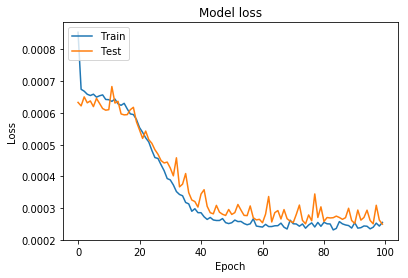

In [11]:
logger.info('Plotting loss function')
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

INFO:root:Plotting predictions before inverse scaling


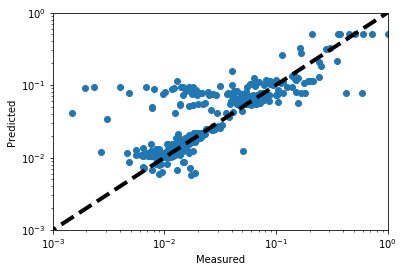

In [12]:
# reasonable correlation between predicted and measured IR7 lifetime (here shown before inverse scaling)
# shows that there is potential to predict instantaneous beam loss rate from operational parameters, through a dedicated neural network
# non-linearities are still present, indicating that the model can be further improved

logger.info('Plotting predictions before inverse scaling')
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-3,1)
plt.xlim(1e-3,1)
plt.show()

INFO:root:Plotting predictions after inverse scaling


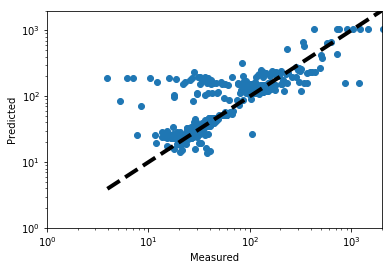

In [14]:
y_test = sc.inverse_transform(y_test)
y_pred = sc.inverse_transform(y_pred)

logger.info('Plotting predictions after inverse scaling')
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1,2000)
plt.xlim(1,2000)
plt.show()